# **Assignment 3 - Part C_2**

## **Mid level: Using tensorflow to build a 3 layer neural network with auto differentiation (gradient-tape).**


In [1]:
##Importing the required libraries
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow as tf

In [2]:
##Initializing the weights tensor - 2*3 shape
a = tf.constant([[1,2,3], [4,5,6]])
a.shape

TensorShape([2, 3])

In [3]:
##Initializing the bias
bias = tf.constant([[1], [0.5]])
bias.shape

TensorShape([2, 1])

In [4]:
##Generate random values for x - shape: 500 * 3
n = 500
d = 3
x = tf.random.normal([n,d], -1, 1, tf.float64, seed=1)
x.shape

TensorShape([500, 3])

In [5]:
##Generating 3d non-linear input and calculating y_true values
a = tf.cast(a, tf.float64)
bias = tf.cast(bias, tf.float64)
x = tf.cast(x, tf.float64)

## y1 = x_1^2 + 2 * x_2^2 + 3 * x_3^2 + x_1 + 2 * x_2 + 3 * x_3 + 1
## y2 = 4 * x_1^2 + 5 * x_2^2 + 6 * x_3^2 + 4 * x_1 + 5 * x_2 + 6 * x_3 + 0.5
##Calculating actual output for the data

a = tf.transpose(a)
bias = tf.transpose(bias)
y_true = tf.matmul(x ** 2, a) + tf.matmul(x, a) + bias

##Checking shapes for input, weight, bias and output tensors
print(f'x: {x.shape}, weights: {a.shape}, bias: {bias.shape}, y: {y_true.shape}')

x: (500, 3), weights: (3, 2), bias: (1, 2), y: (500, 2)


In [6]:
##Visualizing the data distribution using TSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_jobs=5).fit_transform(x)
tsne.shape

(500, 2)

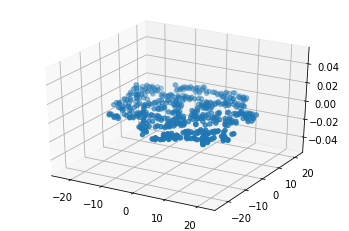

In [7]:
##To see the shape of data generated
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*zip(*tsne))
plt.show()

In [8]:
##Function for tsne plot visualization
def tsne_plot(tsne, y, y_pred=None):
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(tsne[:, 0], tsne[:, 1], y[:, 0], label='underlying function')
  if y_pred is not None:
    ax.scatter(tsne[:, 0], tsne[:, 1], y_pred[:, 0], label='our function')
  plt.legend()

In [9]:
##Defining the linear layer
class Linear(keras.layers.Layer):
    def __init__(self, units=32):
        super(Linear, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

In [10]:
##Defining the loss function
class ActivityRegularization(keras.layers.Layer):
  """Layer that creates an activity sparsity regularization loss."""
  
  def __init__(self, rate=1e-2):
    super(ActivityRegularization, self).__init__()
    self.rate = rate
  
  def call(self, inputs):
    # We use `add_loss` to create a regularization loss
    # that depends on the inputs.
    self.add_loss(self.rate * tf.reduce_sum(inputs))
    return inputs

In [11]:
##Defining the model
class MLPBlock(keras.layers.Layer):
    def __init__(self):
        super(MLPBlock, self).__init__()
        self.linear_1 = Linear(10)
        self.regularization = ActivityRegularization(1e-2)
        self.linear_2 = Linear(2)

    def call(self, inputs):
        x = self.linear_1(inputs)
        x = tf.nn.relu(x)
        x = self.regularization(x)
        # x = self.linear_2(x)
        return self.linear_2(x)

mlp = MLPBlock()
y = mlp(x)  # The first call to the `mlp` will create the weights
print("weights:", len(mlp.weights))
print("trainable weights:", len(mlp.trainable_weights))
print(mlp.losses)

weights: 4
trainable weights: 4
[<tf.Tensor: shape=(), dtype=float32, numpy=3.680177>]


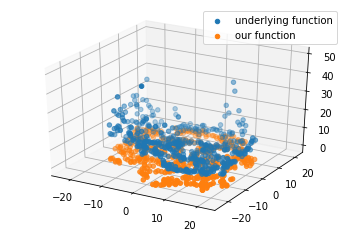

In [12]:
##Visualizing the data distribution using TSNE
tsne_plot(tsne, y_true, mlp(x))

In [13]:
# Loss and optimizer.
##Using gradientTape as auto differentiation
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
y_pred = mlp(x)
for epoch in range(20):
  with tf.GradientTape() as tape:

    # Forward pass.
    y_pred = mlp(x)
    
    loss = mlp.losses
    
    # External loss value for this batch.
    # loss = loss_fn(y_true, y_pred)
    
    # Add the losses created during the forward pass.
    loss += sum(mlp.losses)
     
    # Get gradients of weights wrt the loss.
    gradients = tape.gradient(loss, mlp.trainable_weights)
  
  # Update the weights of our linear layer.
  optimizer.apply_gradients(zip(gradients, mlp.trainable_weights))

  # Logging.
  print('Step:', epoch, 'Loss:', loss)

Step: 0 Loss: tf.Tensor([7.360354], shape=(1,), dtype=float32)
Step: 1 Loss: tf.Tensor([5.2560654], shape=(1,), dtype=float32)
Step: 2 Loss: tf.Tensor([3.5931604], shape=(1,), dtype=float32)
Step: 3 Loss: tf.Tensor([2.3838515], shape=(1,), dtype=float32)
Step: 4 Loss: tf.Tensor([1.5596744], shape=(1,), dtype=float32)
Step: 5 Loss: tf.Tensor([0.96794933], shape=(1,), dtype=float32)
Step: 6 Loss: tf.Tensor([0.5693403], shape=(1,), dtype=float32)
Step: 7 Loss: tf.Tensor([0.44703063], shape=(1,), dtype=float32)
Step: 8 Loss: tf.Tensor([0.3701377], shape=(1,), dtype=float32)
Step: 9 Loss: tf.Tensor([0.31518778], shape=(1,), dtype=float32)
Step: 10 Loss: tf.Tensor([0.27482757], shape=(1,), dtype=float32)
Step: 11 Loss: tf.Tensor([0.24430272], shape=(1,), dtype=float32)
Step: 12 Loss: tf.Tensor([0.21909381], shape=(1,), dtype=float32)
Step: 13 Loss: tf.Tensor([0.1974517], shape=(1,), dtype=float32)
Step: 14 Loss: tf.Tensor([0.17891742], shape=(1,), dtype=float32)
Step: 15 Loss: tf.Tensor([0.1

We can see that the loss value is going down.

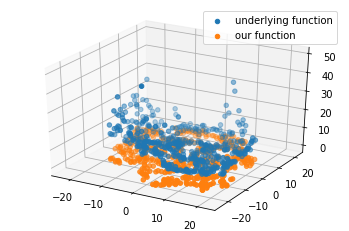

In [14]:
##Visualizing the data distribution using TSNE
tsne_plot(tsne, y_true, mlp(x))